# NLP Feature Engineering

Contents:

* Extracting Basic Features
    - Number of Characters
    - Number of Words
    - Average Word Length
    - Number of Hastags and Mentions (Social Media)
    - Number of Sentences
    - Number of Paragraphs
    - Words Starting with an Uppercase
    - All-capital Words
    - Numeric quantities
* Text Preprocessing
    - Tokenization/Segmentation
    - Lemmatization (and Stemming)
    - Converting to Lowercase
    - Text Cleaning
        - Removing Unnecessary Whitespaces and Escape Squences
        - Removing Punctuations
        - Removing Stopwords or Commonly Occuring Words/Tokens
        - Removing Special Characters (emojis, numbers...)
        - Expanding Contractions (don't, etc.)
* Extracting Word Features
    - Parts-of-Speech (POS) Tagging
    - Named Entity Recognition (NEG)
* Dependency Parsing (Not in the Notebook)
* Vectorization (Convert documents into a set of numerical features)
    - Bag of Words (Bag of n-grams)
    - tf-idf

_Dataset: [troll-tweets](https://github.com/fivethirtyeight/russian-troll-tweets)_

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

from sklearn.model_selection import train_test_split

In [2]:
#df = pd.read_csv("data/IRAhandle_tweets_1.csv")
df = pd.read_pickle("data/tweets1.pkl")

In [9]:
df.head()

,content,author,language,retweet,followers,following
0,"""We have a sitting Democrat US Senator on tria...",10_GOP,English,0,9636,1052
1,Marshawn Lynch arrives to game in anti-Trump s...,10_GOP,English,0,9637,1054
2,Daughter of fallen Navy Sailor delivers powerf...,10_GOP,English,1,9637,1054
3,JUST IN: President Trump dedicates Presidents ...,10_GOP,English,0,9642,1062
4,"19,000 RESPECTING our National Anthem! #StandF...",10_GOP,English,1,9645,1050


In [10]:
df.columns

Index(['content', 'author', 'language', 'retweet', 'followers', 'following'], dtype='object')

In [11]:
df = df[['content', 'author', 'language', 'retweet', 'followers', 'following']]

In [12]:
df.tail()

,content,author,language,retweet,followers,following
243886,BREAKING: Killer avalanche sweeps three skiers...,AUSTINLOVESBEER,English,1,34,41
243887,Why men should support International Women’s D...,AUSTINLOVESBEER,English,1,34,41
243888,How we can rebuild trust in a UK divided by in...,AUSTINLOVESBEER,English,1,34,41
243889,John Humphrys accused of patronising Angela Ra...,AUSTINLOVESBEER,English,1,34,41
243890,Fossilized poop found in 180-million-year-old ...,AUSTINLOVESBEER,English,1,34,41


## Basic Feature Extraction

### Character Count

In [3]:
# Create a feature char_count
df['char_count'] = df['content'].apply(len)

# Print the average character count
print(df['char_count'].mean())

104.59038258894343


The average character count of a tweet is 33-34 characters. However, the average value of this dataset is 104, which is significantly higher than the average. This might prove an important feature.
> The most common length of a tweet back when Twitter only allowed 140 characters was 34 characters. Now that the limit is 280 characters, the most common length of a tweet is 33 characters. Historically, only 9% of tweets hit Twitter’s 140-character limit, now it’s 1%. [source](https://techcrunch.com/2018/10/30/twitters-doubling-of-character-count-from-140-to-280-had-little-impact-on-length-of-tweets/)

### Word Counts

In [4]:
def count_words(string):
    '''Returns number of words in a string'''
    
    # Split the string into words
    words = string.split()
    
    # Return the number of words
    return len(words)

In [5]:
# Create a new feature word_count
df['word_count'] = df.content.apply(count_words)

# Print the average word count of the talks
print(df['word_count'].mean())

13.396980618391003


We can compute the correlation of `word_count` with other features and derive interesting insights.

### Sentence Counts 

In [6]:
def count_sentences(string):
    '''Returns number of sentences in a string'''
    
    # Split the string into sentences
    words = string.split('.')
    
    # Return the number of sentences
    return len(words)

In [7]:
# Create a new feature word_count
df['sentence_count'] = df.content.apply(count_sentences)

# Print the average word count of the talks
print(df['sentence_count'].mean())

2.604028028914556


### Hashtag and Mention Counts

In [8]:
def count_hashtags(string):
    '''Returns number of hashtags in a string.'''
    
    # Split the string into words
    words = string.split()
    
    # Create a list of words that are hashtags
    hashtags = [word for word in words if word.startswith("#")]
    
    # Return number of hashtags
    return(len(hashtags))

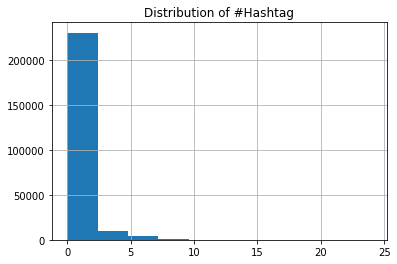

In [9]:
# Create a feature hashtag_count
df['hashtag_count'] = df['content'].apply(count_hashtags)

# Plot the distribution
df['hashtag_count'].hist()
plt.title('Distribution of #Hashtag')
plt.show()

In [10]:
def count_mentions(string):
    '''Returns number of mentions in a string.'''
    
    # Split the string into words
    words = string.split()
    
    # Create a list of words that are mentions
    mentions = [word for word in words if word.startswith("@")]
    
    # Return number of mentions
    return(len(mentions))

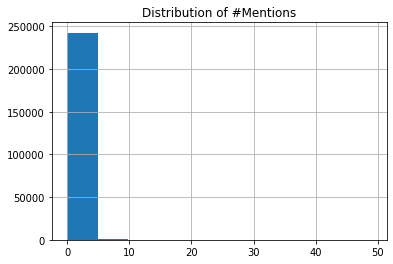

In [11]:
# Create a feature mention_count
df['mention_count'] = df['content'].apply(count_mentions)

# Plot the distribution
df['mention_count'].hist()
plt.title('Distribution of #Mentions')
plt.show()

## Readability Test (reading-ease score)

Readability tests or readability metrics are formulae for evaluating the readability of text, usually by counting syllables, words, and sentences. [wikipedia](https://en.wikipedia.org/wiki/Readability_test)

The Flesch–Kincaid readability tests are readability tests designed to indicate how difficult a passage in English is to understand. In the Flesch reading-ease test, higher scores indicate material that is easier to read; lower numbers mark passages that are more difficult to read. [wikipedia](https://en.wikipedia.org/wiki/Flesch–Kincaid_readability_tests)

![flesch](https://wikimedia.org/api/rest_v1/media/math/render/svg/bd4916e193d2f96fa3b74ee258aaa6fe242e110e)

Score|Difficulty
-----|:---------
90-100|Very Easy
80-89|Easy
70-79|Fairly Easy
60-69|Standard
50-59|Fairly Difficult
30-49|Difficult
0-29|Very Confusing

In [57]:
# # Read Flesch reading-ease score from wikipedia
# url = 'https://en.wikipedia.org/wiki/Flesch–Kincaid_readability_tests'
# flesch = pd.read_html(url)

In [36]:
#!pip install textstat

In [37]:
# import textstat

# df.content.apply(textstat.flesch_reading_ease)

# ### While the maximum score is 121.22, there is no limit on how low the score can be. A negative score is valid.

In [35]:
#flesch_score = 206.835 - 1.015 * (df.word_count / df.sentence_count) - 84.6 * (num_syllables / df.word_count)

## Text Preprocessing

### Tokenization

In [15]:
#import spacy

# Load the en_core_web_sm (or en) model
#nlp = spacy.load('en')
nlp = spacy.load('en_core_web_sm')

# Create a Doc object
doc = nlp("Hello world. How are you?")

# Generate the tokens
tokens = [token.text for token in doc]
print(tokens)

['Hello', 'world', '.', 'How', 'are', 'you', '?']


### Lemmatization

In [37]:
# Generate lemmas
lemmas = [token.lemma_ for token in doc]

# Convert lemmas into a string
print(' '.join(lemmas))

hello world . how be -PRON- ?


### Text Cleaning

Several _Text Cleaning_ steps are performed if certain information does not additional value for text vectorization. It is better to do _Text Cleaning_  after the _tokenization_ step, since doing it before might cause undesirable effects.

In [46]:
from spacy.lang.en.stop_words import STOP_WORDS

# Remove stopwords and non-alphabetic tokens
a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in STOP_WORDS]

# Print string after text cleaning
print(' '.join(a_lemmas))

hello world


Note that removing all non-alpha words or using a pre-defined stop words may not be ideal in many cases.

In [ ]:
# Function to preprocess text
def preprocess(text):
    # Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in STOP_WORDS]
    
    return ' '.join(a_lemmas)
  
# # Apply preprocess to df['content']
# df['content'] = df['content'].apply(preprocess)
# print(df['content'])

## Extracting Word Features

Spacy has pre-trained neural models for tagging, parsing and entity recognition. 

In [14]:
#!python -m spacy download en_core_web_sm

In [13]:
nlp = spacy.load("en_core_web_sm")

### POS Tagging

In [47]:
# Create a Doc object
doc = nlp("Hello world. How are you?")

# Generate tokens and pos tags
pos = [(token.text, token.pos_) for token in doc]
print(pos)

[('Hello', 'INTJ'), ('world', 'NOUN'), ('.', 'PUNCT'), ('How', 'ADV'), ('are', 'AUX'), ('you', 'PRON'), ('?', 'PUNCT')]


In [48]:
# Returns number of proper nouns
def num_proper_nouns(text, model=nlp):
    # Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    
    # Return number of proper nouns
    return pos.count("PROPN")

print(num_proper_nouns("Turgut, Kahn, and Jakob went to the university.", nlp))

3


In [50]:
# Returns number of other nouns
def num_nouns(text, model=nlp):
    # Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    
    # Return number of other nouns
    return pos.count("NOUN")

print(num_nouns("Turgut, Kahn, and Jakob went to the university.", nlp))

1


In [ ]:
# Compute number of proper nouns
df['num_propn'] = df['content'].apply(num_proper_nouns)

# Compute number of nouns
df['num_noun'] = df['content'].apply(num_nouns)

### Named Entity Recognition (NER)

Possible Uses:

- Classifying/tagging articles by the people mentioned in them
- Detecting people, location, year, etc. in a text

In [20]:
# Create a Doc instance 
text = 'Kyle, Khan, and Turgut went to the university together. They are working in San Jose at Google since 2015.'
doc = nlp(text)

# Print all named entities and their labels
for ent in doc.ents:
    print(ent.text, ent.label_)

Kyle PERSON
Khan PERSON
Turgut GPE
San Jose GPE
Google ORG
2015 DATE


The model correctly predicted the labels of Kyle, Khan, Google, San Jose, and 2015; but mislabeled Turgut as GPE. The reason is that the predictions of the model depend strongly on the data it is trained on. We can train spaCy models on our custom data if required.

#### Identifying People

In [21]:
def find_persons(text):
  # Create Doc object
  doc = nlp(text)
  
  # Identify the persons
  persons = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
  
  # Return persons
  return persons

print(find_persons(text))

['Kyle', 'Khan']


## Vectorization

Vectorization is the general process of turning a collection of text documents into numerical feature vectors.

### Bag of Words (Bag of n-Grams) (BoW)

It is better to perform preprocessing before applying bag-of-words model, since it leads to smaller vocabulary list.

In [5]:
corpus = pd.Series([
    'Two roads diverged in a yellow wood',
    'And sorry I could not travel both', 
    'And be one traveller, long I stood',
    'And looked down one as far as I could',
    'To where it bent in the undergrowth.'
])
# Poem by Frost

#### Count Vectorizer

[CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) converts a collection of text documents to a matrix of token counts. It implements both tokenization and occurrence counting. 



In [30]:
# Create CountVectorizer object
vectorizer = CountVectorizer()
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Generating a bag of words representation for a given corpus of documents: 

In [35]:
# Generate matrix of word vectors
bow_matrix = vectorizer.fit_transform(corpus)

# Print the shape of bow_matrix
print(bow_matrix.shape)

bow_matrix

(5, 27)


<5x27 sparse matrix of type '<class 'numpy.int64'>'
	with 32 stored elements in Compressed Sparse Row format>

In [58]:
bow_matrix.toarray()

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1],
       [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0],
       [1, 2, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 0]])

Generating a bag of words representation for a given corpus of documents: After some preprocessing

In [56]:
from spacy.lang.en.stop_words import STOP_WORDS

# Function to preprocess text
def preprocess(text):
    # Create a Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in STOP_WORDS]
    
    return ' '.join(a_lemmas)
  
# Apply lemmatize to corpus
corpus_prep = corpus.apply(preprocess)

# Print corpus_prep
corpus_prep

0    road diverge yellow wood
1                sorry travel
2        traveller long stand
3                    look far
4            bend undergrowth
dtype: object

In [57]:
# Create CountVectorizer object
vectorizer = CountVectorizer()

# Generate matrix of word vectors
bow_prep_matrix = vectorizer.fit_transform(corpus_prep)

# Print the shape of bow_lem_matrix
print(bow_prep_matrix.shape)

(5, 13)


The number of features reduced significantly from 27 to 13 after preprocessing. While this may have some disadvantages, preprocessing text before vectorizing reduces the dimension and may likely lead to a better performance when applying ML.

#### Preprocessing Using `CountVectorizer`

Some argumens of scikit-learn's `CountVectorizer` allows us to perform basic preprocessing. These are as follows:

- lowercase : False , True
- strip_accents : 'unciode' , 'ascii' , None 
- stop_words : 'english' , list , None 
- token_pattern : regex
- tokenizer : function
 

##### Mapping Indices

In [61]:
# Create CountVectorizer object
vectorizer = CountVectorizer()

# Generate matrix of word vectors
bow_prep_matrix = vectorizer.fit_transform(corpus_prep)

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(bow_prep_matrix.toarray())

# Map the column names to vocabulary 
bow_df.columns = vectorizer.get_feature_names()

# Print bow_df
bow_df

# # Features as a DataFrame
# feature_names = count_vectorizer.get_feature_names()
# df_features = pd.DataFrame(count_train.toarray(), columns = feature_names)
# df_features.head()

,bend,diverge,far,long,look,road,sorry,stand,travel,traveller,undergrowth,wood,yellow
0,0,1,0,0,0,1,0,0,0,0,0,1,1
1,0,0,0,0,0,0,1,0,1,0,0,0,0
2,0,0,0,1,0,0,0,1,0,1,0,0,0
3,0,0,1,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,1,0,0


The column names refer to the tokens.

In [67]:
# Merge corpus with bow df
pd.DataFrame(corpus.rename("corpus")).join(bow_df)

,corpus,bend,diverge,far,long,look,road,sorry,stand,travel,traveller,undergrowth,wood,yellow
0,Two roads diverged in a yellow wood,0,1,0,0,0,1,0,0,0,0,0,1,1
1,And sorry I could not travel both,0,0,0,0,0,0,1,0,1,0,0,0,0
2,"And be one traveller, long I stood",0,0,0,1,0,0,0,1,0,1,0,0,0
3,And looked down one as far as I could,0,0,1,0,1,0,0,0,0,0,0,0,0
4,To where it bent in the undergrowth.,1,0,0,0,0,0,0,0,0,0,1,0,0


### BoW Classifier

In [ ]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

#### BoW Model (Representation)

In [ ]:
# Create a CountVectorizer object
vectorizer = CountVectorizer(lowercase=True, stop_words="english")

# Fit and transform X_train
X_train_bow = vectorizer.fit_transform(X_train)

# Transform X_test
X_test_bow = vectorizer.transform(X_test)

# Print shape of X_train_bow and X_test_bow
print(X_train_bow.shape)
print(X_test_bow.shape)

### Classification Model

In [ ]:
# Create a MultinomialNB object
clf = MultinomialNB()

# Fit the classifier
clf.fit(X_train_bow, y_train)

# Measure the accuracy
accuracy = clf.score(X_test_bow, y_test)
print("The accuracy of the classifier on the test set is %.3f" % accuracy)

# Predict the sentiment of a negative review
review = "The movie was terrible. The music was underwhelming and the acting mediocre."
prediction = clf.predict(vectorizer.transform([review]))[0]
print("The sentiment predicted by the classifier is %i" % (prediction))

### n-gram Models

Applications:


In [70]:
# Generate n-grams upto n=1
vectorizer_ng1 = CountVectorizer(ngram_range=(1,1))
ng1 = vectorizer_ng1.fit_transform(corpus)

# Generate n-grams upto n=2
vectorizer_ng2 = CountVectorizer(ngram_range=(1,2))
ng2 = vectorizer_ng2.fit_transform(corpus)

# Generate n-grams upto n=3
vectorizer_ng3 = CountVectorizer(ngram_range=(1, 3))
ng3 = vectorizer_ng3.fit_transform(corpus)

# Print the number of features for each model
print("ng1, ng2 and ng3 have %i, %i and %i features respectively." % (ng1.shape[1], ng2.shape[1], ng3.shape[1]))

ng1, ng2 and ng3 have 27, 55 and 78 features respectively.


In [ ]:
# Define an instance of MultinomialNB 
clf_ng = MultinomialNB()

# Fit the classifier 
clf_ng.fit(X_train_ng, y_train)

# Measure the accuracy 
accuracy = clf_ng.score(X_test_ng, y_test)
print("The accuracy of the classifier on the test set is %.3f" % accuracy)

# Predict the sentiment of a negative review
review = "The movie was not good. The plot had several holes and the acting lacked panache."
prediction = clf_ng.predict(ng_vectorizer.transform([review]))[0]
print("The sentiment predicted by the classifier is %i" % (prediction))

#### Comparing Performance

I will compare the performance using three criteria: accuracy of the model on the test set, time taken to execute and the number of features created when generating the n-gram representation.

In [ ]:
start_time = time.time()
# Splitting the data into training and test sets
train_X, test_X, train_y, test_y = train_test_split(df['review'], df['sentiment'], test_size=0.5, 
                                                    random_state=42, stratify=df['sentiment'])

# Generating ngrams
vectorizer = CountVectorizer()
train_X = vectorizer.fit_transform(train_X)
test_X = vectorizer.transform(test_X)

# Fit classifier
clf = MultinomialNB()
clf.fit(train_X, train_y)

# Print accuracy, time and number of dimensions
print("The program took %.3f seconds to complete. The accuracy on the test set is %.2f. The ngram representation had %i features." % (time.time() - start_time, clf.score(test_X, test_y), train_X.shape[1]))

In [ ]:
start_time = time.time()
# Splitting the data into training and test sets
train_X, test_X, train_y, test_y = train_test_split(df['review'], df['sentiment'], test_size=0.5, 
                                                    random_state=42, stratify=df['sentiment'])

# Generating ngrams
vectorizer = CountVectorizer(ngram_range=(1,3))
train_X = vectorizer.fit_transform(train_X)
test_X = vectorizer.transform(test_X)

# Fit classifier
clf = MultinomialNB()
clf.fit(train_X, train_y)

# Print accuracy, time and number of dimensions
print("The program took %.3f seconds to complete. The accuracy on the test set is %.2f. The ngram representation had %i features." % (time.time() - start_time, clf.score(test_X, test_y), train_X.shape[1]))

Despite taking higher computation time and generating more features, the classifier only performs marginally better in the latter case, producing an accuracy of 77% in comparison to the 75% for the unigram model.

### tf-idf (term frequency - inverse document frequency)

Possible applications:
- Automatically detect stopwords
- Search
- Recommender systems
- Better performance in predictive modeling for some cases

In [3]:
ted = pd.read_csv("data/fe/ted.csv")

In [4]:
ted = ted.transcript
ted.head(3)

0    We're going to talk — my — a new lecture, just...
1    This is a representation of your brain, and yo...
2    It's a great honor today to share with you The...
Name: transcript, dtype: object

In [87]:
# Create TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Generate matrix of word vectors
tfidf_matrix = vectorizer.fit_transform(ted)

# Print the shape of tfidf_matrix
print(tfidf_matrix.shape)

(500, 29158)


In [103]:
indices = np.random.randint(29158, size=10)
np.asarray(vectorizer.get_feature_names())[indices].tolist()

['tyrannous',
 'extraordinarily',
 'plumbers',
 'camara',
 'orientation',
 'dot',
 'kyunki',
 'preconceptions',
 'submerge',
 'hamburger']

### Similarity Scores (Cosine Similarity)

In [8]:
corpus

0      Two roads diverged in a yellow wood
1        And sorry I could not travel both
2       And be one traveller, long I stood
3    And looked down one as far as I could
4     To where it bent in the undergrowth.
dtype: object

In [7]:
# Initialize an instance of tf-idf Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Generate the tf-idf vectors for the corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Compute and print the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.         0.         0.         0.10617563]
 [0.         1.         0.0879537  0.16458645 0.        ]
 [0.         0.0879537  1.         0.16458645 0.        ]
 [0.         0.16458645 0.16458645 1.         0.        ]
 [0.10617563 0.         0.         0.         1.        ]]


In [ ]:
    [[1.         0.36413198 0.18314713 0.18435251 0.16336438]
     [0.36413198 1.         0.15054075 0.21704584 0.11203887]
     [0.18314713 0.15054075 1.         0.21318602 0.07763512]
     [0.18435251 0.21704584 0.21318602 1.         0.12960089]
     [0.16336438 0.11203887 0.07763512 0.12960089 1.        ]]


From the similarity matrix, we see that the second and the fourth sentences (+ the third and the fourth) are the most similar. Also the first and the fifth sentences have, on average, the lowest pairwise cosine scores. This is intuitive as they contain entities that are not present in the other sentences.

### Recommender Systems Using tf-idf and Cosine Similarity Matrix

Steps:
- Text Preprocessing
- Generating Tf-idf Vectors
- Generating Cosine Similarity Matrix

When we're working with large data, it is a good practice to use  `linear_kernel` instead of `cosine_similarity` to improve performance, since both give same result when the vectors are in the `tf-idf` representation. 

In [56]:
movie = pd.read_csv("data/fe/movie_overviews.csv", usecols=[1,2])
movie = movie.dropna().reset_index(drop=True)

In [57]:
movie.head()

,title,overview
0,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,Jumanji,When siblings Judy and Peter discover an encha...
2,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom..."
4,Father of the Bride Part II,Just when George Banks has recovered from his ...


In [58]:
# Generate mapping between titles and index
indices = pd.Series(movie.index, index=movie['title']).drop_duplicates()

def get_recommendations(title, cosine_sim, indices):
    # Get index of movie that matches title
    idx = indices[title]
    # Sort the movies based on the similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores for 10 most similar movies
    sim_scores = sim_scores[1:11]
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    # Return the top 10 most similar movies
    return movie['title'].iloc[movie_indices]

In [59]:
# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer(stop_words = "english")

# Construct the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(movie.overview)

# Generate the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
 
# Generate recommendations 
print(get_recommendations('The Dark Knight Rises', cosine_sim, indices))

132                              Batman Forever
6902                            The Dark Knight
1113                             Batman Returns
7567                 Batman: Under the Red Hood
523                                      Batman
7901                           Batman: Year One
8164    Batman: The Dark Knight Returns, Part 1
2576               Batman: Mask of the Phantasm
8225    Batman: The Dark Knight Returns, Part 2
6145                              Batman Begins
Name: title, dtype: object


### Word Embeddings

#### Generating Word Vectors

In [68]:
# Load the en_core_web_lg
nlp = spacy.load('en_core_web_sm')

# Create the doc object
doc = nlp('I like bananas and apples')

# Compute pairwise similarity scores
for token1 in doc:
  for token2 in doc:
    print(token1.text, token2.text, token1.similarity(token2))

I I 1.0
I like 0.18428169
I bananas 0.14788893
I and -0.03217984
I apples 0.052373044
like I 0.18428169
like like 1.0
like bananas 0.10241573
like and 0.1815342
like apples 0.12026104
bananas I 0.14788893
bananas like 0.10241573
bananas bananas 1.0
bananas and -0.11511948
bananas apples 0.6352397
and I -0.03217984
and like 0.1815342


/Users/stb/anaconda3/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/stb/anaconda3/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use

and bananas -0.11511948
and and 1.0
and apples 0.0039500236
apples I 0.052373044
apples like 0.12026104
apples bananas 0.6352397
apples and 0.0039500236
apples apples 1.0


/Users/stb/anaconda3/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
/Users/stb/anaconda3/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use

#### Computing Similarity

In [ ]:
# Create Doc objects
mother_doc = nlp(mother)
hopes_doc = nlp(hopes)
hey_doc = nlp(hey)

# Print similarity between mother and hopes
print(mother_doc.similarity(hopes_doc))

# Print similarity between mother and hey
print(mother_doc.similarity(hey_doc))